# 0. Setting up th GPU's

In [ ]:
# Import os for file path management
import os

# Set the CUDA_VISIBLE_DEVICES variable to specify which GPUs to use (0 and 1 in this case)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# 1. Setup Mario

In [2]:
# Import the game
import gym_super_mario_bros
# Import the joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# Import the COMPLEXIFIED controls
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

In [2]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)

# 2. Preprocess Environment

In [3]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import FrameStack, GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [4]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, COMPLEX_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [5]:
state = env.reset()
state.shape

(1, 240, 256, 4)

In [6]:
COMPLEX_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left'],
 ['left', 'A'],
 ['left', 'B'],
 ['left', 'A', 'B'],
 ['down'],
 ['up']]

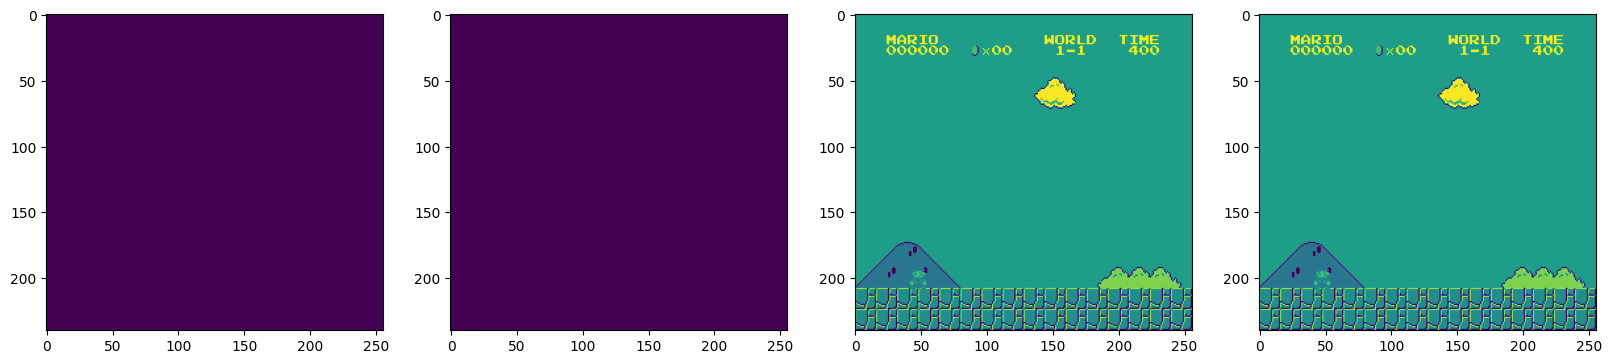

In [7]:
state, reward, done, info = env.step([5]) # 5 because it makes mario jump

plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [5]:
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [5]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [10]:
class RenderCallback(BaseCallback):
    def __init__(self, render_freq):
        super(RenderCallback, self).__init__()
        self.render_freq = render_freq

    def _on_step(self):
        if self.n_calls % self.render_freq == 0:
            self.model.env.render()

        return True

In [9]:
CHECKPOINT_DIR = './models/'
LOG_DIR = './logs/'

In [12]:
# Setup model saving and rendering callbacks
callback_save = TrainAndLoggingCallback(check_freq=1000000, save_path=CHECKPOINT_DIR)
callback_render = RenderCallback(render_freq=10)

In [ ]:
callback = [callback_save, callback_render]

In [13]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1,
            tensorboard_log=LOG_DIR,
            learning_rate=0.000001,
            n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [14]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=10000000, callback=callback)

Logging to ./logs/PPO_1
----------------------------
| time/              |     |
|    fps             | 163 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 89            |
|    iterations           | 2             |
|    time_elapsed         | 11            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.0456308e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.48         |
|    explained_variance   | -0.0011       |
|    learning_rate        | 1e-06         |
|    loss                 | 2.94          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000538     |
|    value_loss           | 6.46          |
-------------------------

c:\Users\vibha\miniconda3\envs\py38\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-------------------------------------------
| time/                   |               |
|    fps                  | 83            |
|    iterations           | 3             |
|    time_elapsed         | 18            |
|    total_timesteps      | 1536          |
| train/                  |               |
|    approx_kl            | 1.2975535e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.48         |
|    explained_variance   | -0.00842      |
|    learning_rate        | 1e-06         |
|    loss                 | 3.27          |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.000606     |
|    value_loss           | 6.29          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 80            |
|    iterations           | 4             |
|    time_elapsed         | 25  

KeyboardInterrupt: 

# 4. Test it Out

In [6]:
# Load model
model = PPO.load('./models/best_model_10000000')

In [7]:
state = env.reset()

In [8]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

c:\Users\vibha\miniconda3\envs\py38\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\vibha\miniconda3\envs\py38\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [46]:
# Close the game
env.close()